## Proyecto Datos Masivos

Genera un buscador de imágenes usando MinHash y visualiza la imagen con mayor similitud de Jaccard, MinMax y Coseno.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Visualización del conjunto de imagenes de entrenamiento 

In [47]:
def impresion_imagenes(df, rango):
    plt.figure(figsize=(10,5))
    for k,i in enumerate(df.values.tolist()[:rango]):
        plt.subplot(2, rango//2, k + 1)
        imox = plt.imread('./imagenes/' + i[0] + '.jpg')
        plt.imshow(imox)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
lista_val = pd.read_csv("paris_bolsas/lista_val_paris.txt", sep = "\n", names = ["Nombre"])

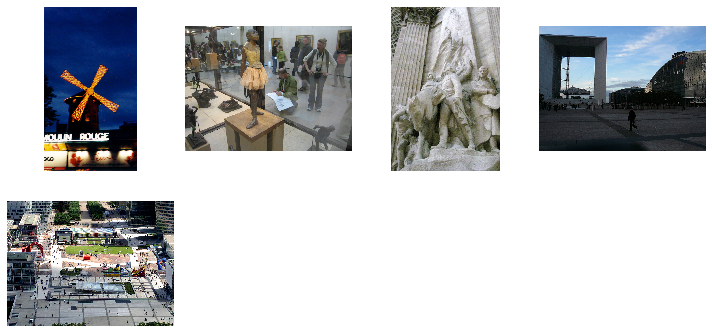

In [26]:
impresion_imagenes(lista_val, 5)

## Visualización del conjunto de imagenes de validación 

In [11]:
lista_entrenamiento = pd.read_csv("paris_bolsas/lista_ent_paris.txt", sep = "\n", names = ["Nombre"])

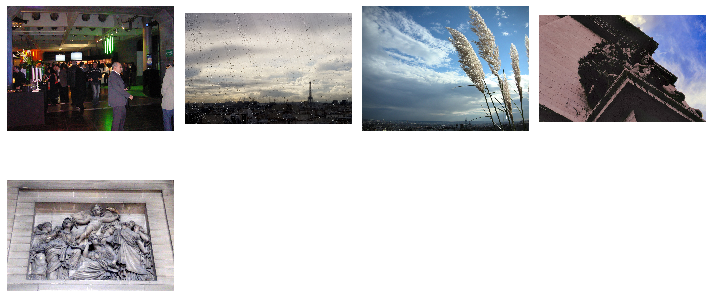

In [27]:
impresion_imagenes(lista_entrenamiento,5)

Utilizando la clase TablaMinHash vista en clase

In [13]:
class TablaMinHash:
    def __init__(self, n_cubetas, t_tupla, dim):
        self.n_cubetas = n_cubetas
        self.tabla = [[] for i in range(n_cubetas)]
        self.dim = dim
        self.t_tupla = t_tupla
        self.perm = np.random.randint(0, np.iinfo(np.int32).max, size=(self.dim, self.t_tupla))
        self.rind = np.random.randint(0, np.iinfo(np.int32).max, size=(self.dim, self.t_tupla))
        self.a = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
        self.b = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
        self.primo = 4294967291

    def __repr__(self):
        contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas)]
        return "<TablaHash :%s >" % ('\n'.join(contenido))

    def __str__(self):
        contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas) if self.tabla[i]]
        return '\n'.join(contenido)

    def sl(self, x, i):
        return (self.h(x) + i) % self.n_cubetas

    def h(self, x):
        return x % self.primo

    def minhash(self, x):
        xp = self.perm[np.array(x) - 1]
        xi = self.rind[np.array(x) - 1]
        amin = xp.argmin(axis = 0)

        pmin = xp[amin, np.arange(0, self.t_tupla)]
        emin = xi[amin, np.arange(0, self.t_tupla)]

        return np.sum(self.a * pmin, dtype=np.ulonglong), np.sum(self.b * emin, dtype=np.ulonglong)

    def insertar(self, x, ident):
        mh, v2 = self.minhash(x)

        llena = True
        for i in range(self.n_cubetas):
            cubeta = int(self.sl(v2, i))
            if not self.tabla[cubeta]:
                self.tabla[cubeta].append(mh)
                self.tabla[cubeta].append([ident])
                llena = False
                break
            elif self.tabla[cubeta][0] == mh:
                self.tabla[cubeta][1].append(ident)
                llena = False
                break

        if llena:
            print('¡Error, tabla llena!')

    def buscar(self, x):
        mh, v2 = self.minhash(x)

        for i in range(self.n_cubetas):
            cubeta = int(self.sl(v2, i))
            if not self.tabla[cubeta]:
                return []
            elif self.tabla[cubeta][0] == mh:
                return self.tabla[cubeta][1]
            else:  
                return []

## Funciones de similitud 

Debajo están las funciones de similitud de coseno y jaccard definidas

In [14]:
def similitud_jaccard(x, y):
    inter = 0
    for e in x:
        if e in y:
            inter += 1

    return inter / (len(x) + len(y) - inter)

def similitud_coseno(x, y):
    return np.arccos(np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)))

def fuerza_bruta(ds, qs, fd):
    medidas = np.zeros(len(ds))
    for i,x in enumerate(ds):
        medidas[i] = fd(qs, x)

    return np.sort(medidas)[::-1], np.argsort(medidas)[::-1]

def lee_bolsa(ruta):
    numero = []
    bolsa = []
    with open(ruta, 'r') as f:
        for l in f.readlines():
            bolsa.append(l.split(" ")[1:])
            numero.append(l.split(" ")[0])
    return bolsa, numero

In [15]:

bolsa_caracteristicas, numero = lee_bolsa("paris_bolsas/paris_ent_corpus.txt")
bolsa_entrenamiento = [[int(car.split(":")[0]) for car in bolsa] for bolsa in bolsa_caracteristicas]


bolsa_caracteristicas, numero = lee_bolsa("paris_bolsas/paris_val_corpus.txt")
bolsa_val = [[int(car.split(":")[0]) for car in bolsa] for bolsa in bolsa_caracteristicas]

n_tablas = 100
tablas = [TablaMinHash(2**19, 2, 1000000) for _ in range(n_tablas)]

In [16]:
for j,l in enumerate(bolsa_entrenamiento):
    if l:
        for i in range(n_tablas):
            tablas[i].insertar(l, j)

In [17]:
docs = []
for j,l in enumerate(bolsa_val):
    dc = []
    if l:
        for i in range(n_tablas):
            dc.extend(tablas[i].buscar(l))
    docs.append(set(dc))

In [18]:
sims = []
orden = []
for i,q in enumerate(bolsa_val):
    ld = list(docs[i])
    if ld:
        s,o = fuerza_bruta([bolsa_entrenamiento[k] for k in ld], q, similitud_jaccard)
        sims.append(s)
        orden.append([ld[e] for e in o])
    else:
        sims.append([])
        orden.append([])

In [19]:
tams = [len(o) for o in orden]
t_max = np.array(tams).argmax()

In [20]:
lista_val.values[0]

array(['paris_moulinrouge_000529'], dtype=object)

In [51]:
similares = []

for i in range(tams[t_max]):
      similares.append(lista_entrenamiento.values[orden[t_max][i]])

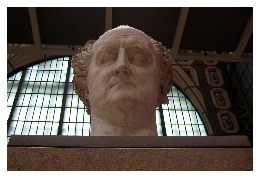

In [59]:
imagen = lista_entrenamiento.values[t_max]
impresion_imagenes(pd.DataFrame(imagen), 2)

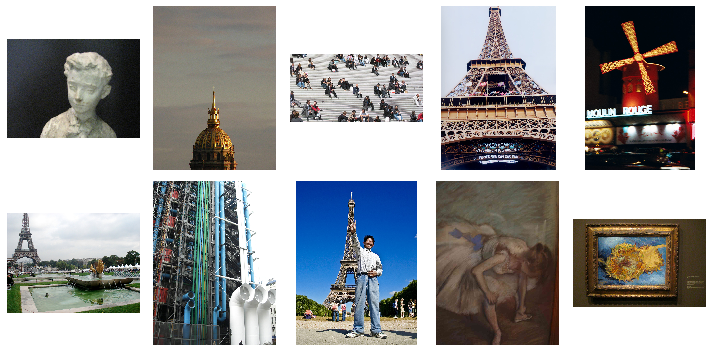

In [53]:
impresion_imagenes(pd.DataFrame(similares), 10)